1. Importa las librerías necesarias para entrenar modelos de regresión logística con
validación cruzada y Extreme Gradient Boosting, carga los datos y prepáralos. Para
ello:
a. elimina la columna ‘Unnamed: 0’.
b. codifica la variable objetivo Category en dos categorías: una para
Category=’0=Blood Donor’, a la que debes asociar valor 0, y un 1 para los
demás valores. Asigna estos valores en una nueva columna llamada target.
c. codifica en otra columna, con nombre suspect, con valor 1 cuando
Category=’0s=suspect Blood Donor’, y aigna 0 en caso contrario. Elimina
finalmente la columna Category.
d. Revisa si la base de datos contiene valores ausentes. En caso que sea así,
aplica los siguientes criterios:
i. si el porcentaje de valores ausentes para alguna variable es menor a
1%, entonces elimina las filas que contengan estos valores ausentes
ii. si el porcentaje de valores ausentes es mayor, entonces reemplaza
estos por el promedio según la clase a la que pertenezca el valor
ausente.
e. Realiza un análisis descriptivo para cada variable regresora, usando gráficos
para representar distribuciones y boxplot para revisar posibles outliers.
Construye un heatmap que muestre las correlaciones entre las variables
regresoras y describe.
f. Transforma las variables regresoras por medio de la estandarización.
Muestra el antes y después de esta usando boxplots, y realiza una
segmentación de la muestra en 33% para test y el resto para entrenamiento


        Category  Age Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA   
0  0=Blood Donor   32   m  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0  \
1  0=Blood Donor   32   m  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0   
2  0=Blood Donor   32   m  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0   
3  0=Blood Donor   32   m  43.2  52.0  30.6  22.6  18.9   7.33  4.74   80.0   
4  0=Blood Donor   32   m  39.2  74.1  32.6  24.8   9.6   9.15  4.32   76.0   

    GGT  PROT  
0  12.1  69.0  
1  15.6  76.5  
2  33.2  79.3  
3  33.8  75.7  
4  29.9  68.7  
Index(['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')
   Age Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA   GGT  PROT   
0   32   m  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0  12.1  69.0  \
1   32   m  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0  15.6  76.5   
2   32   m  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0  33.

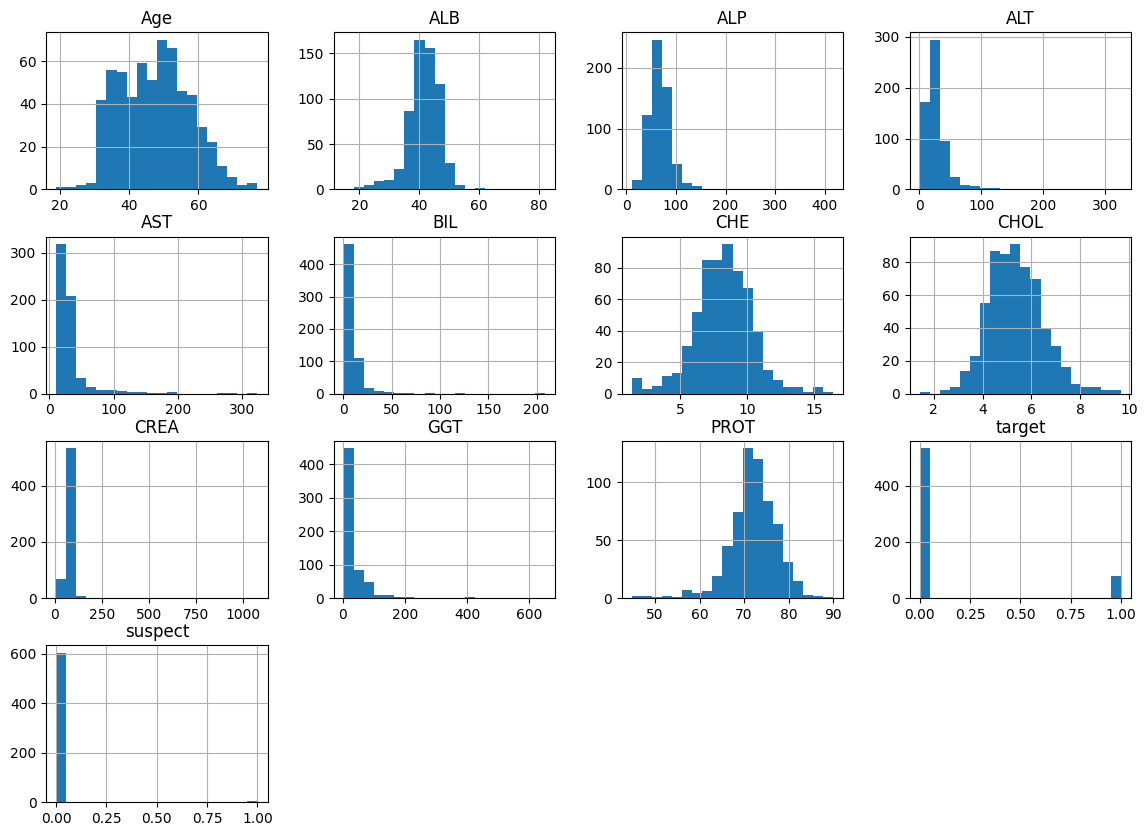

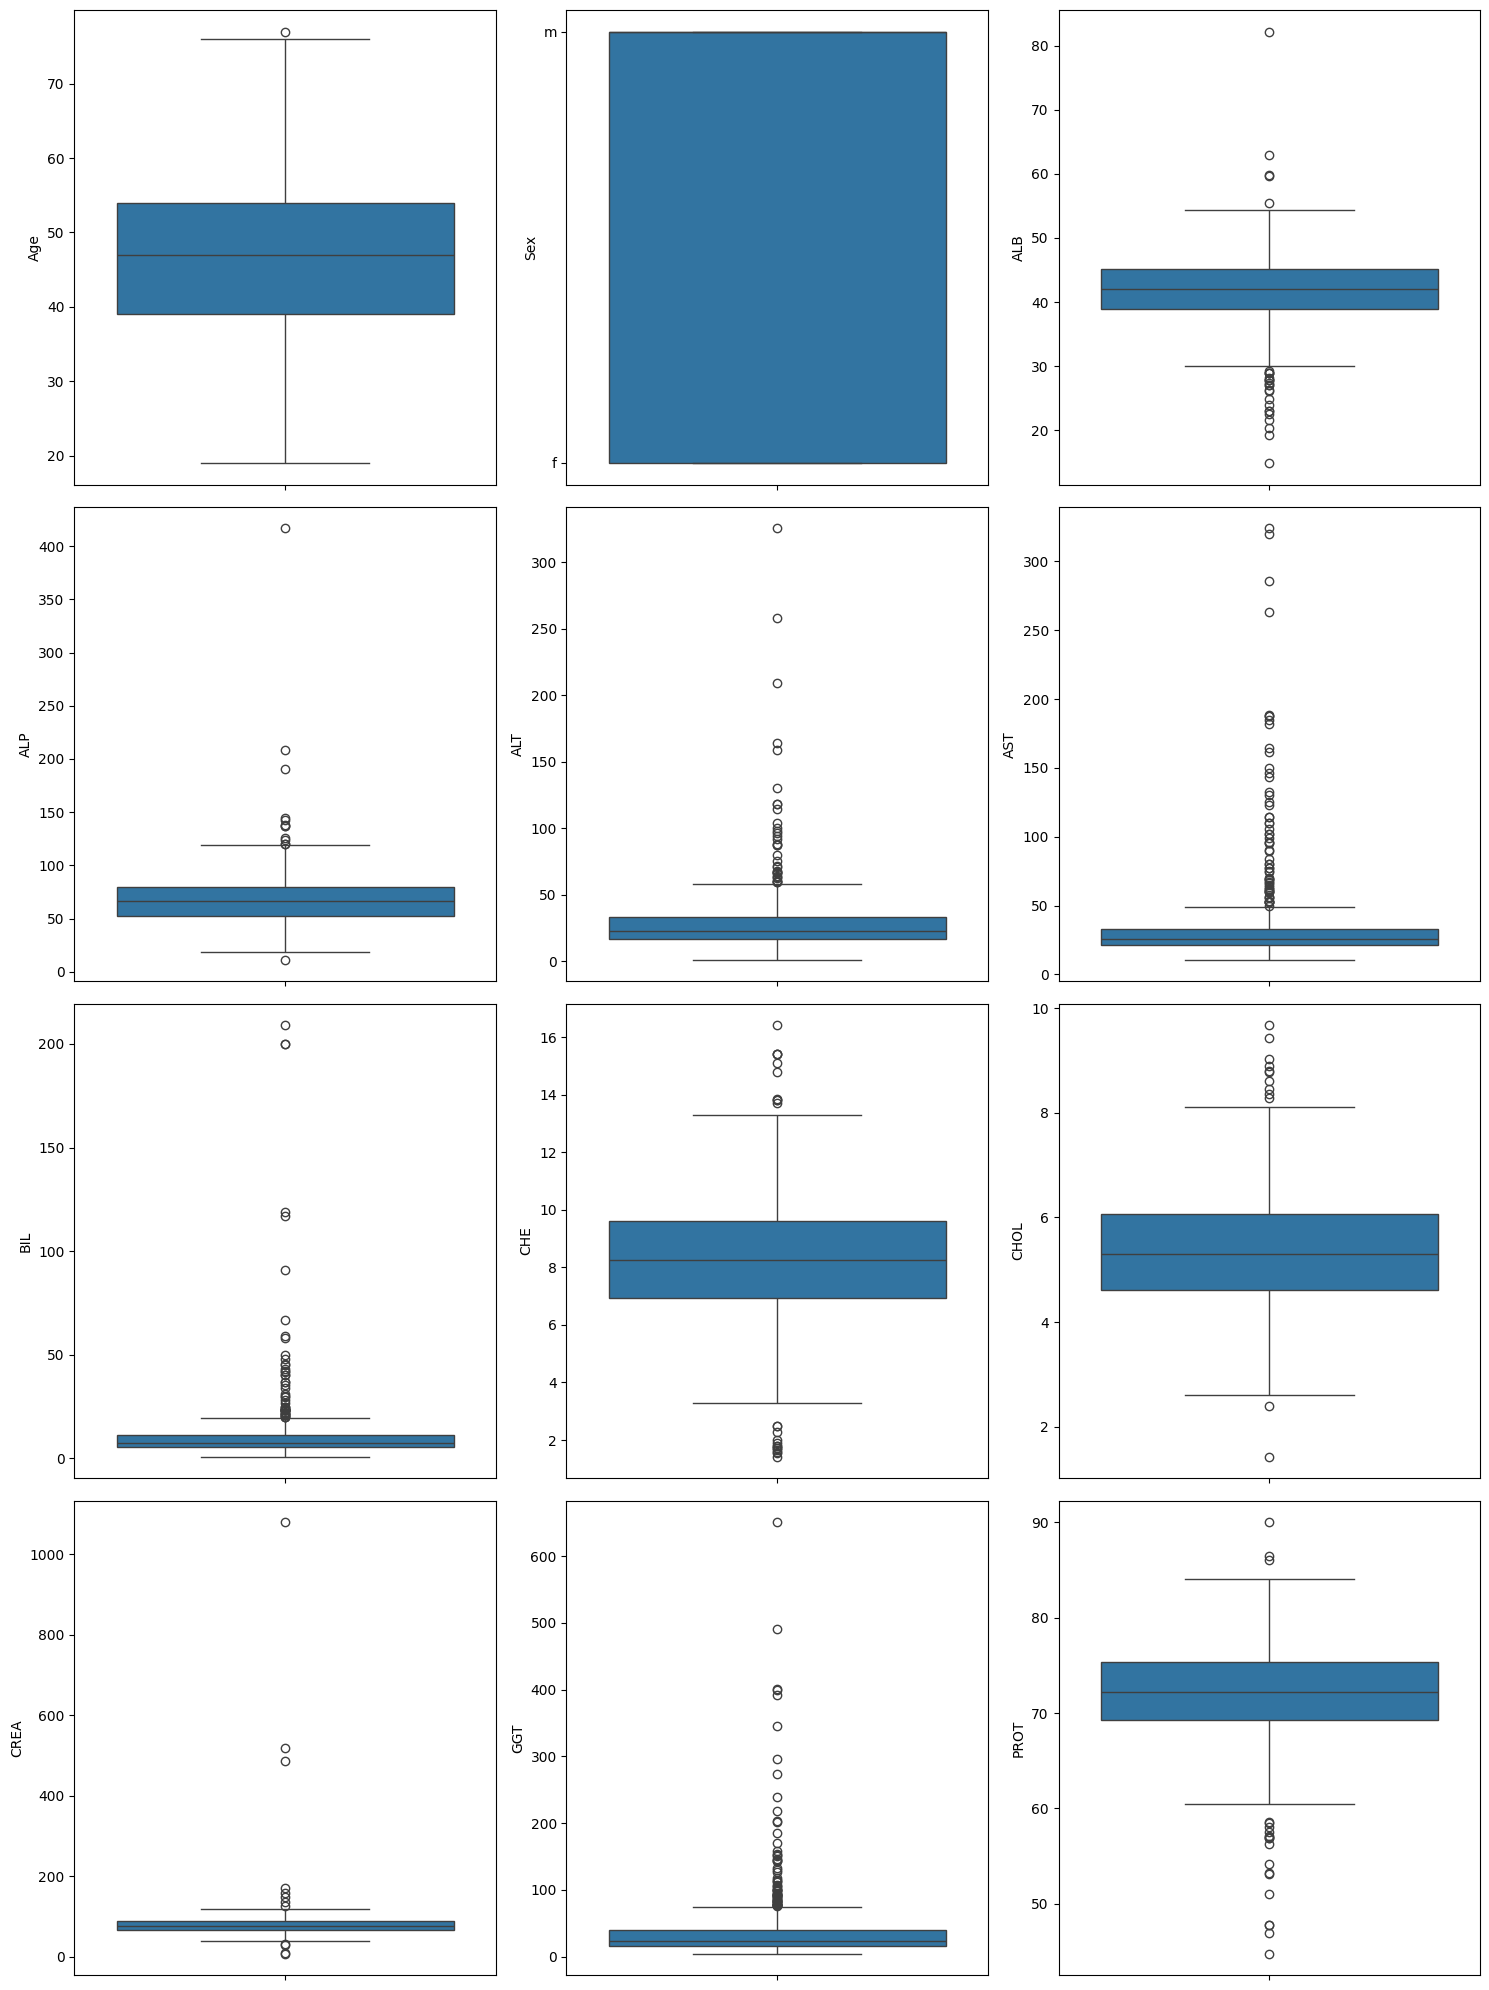

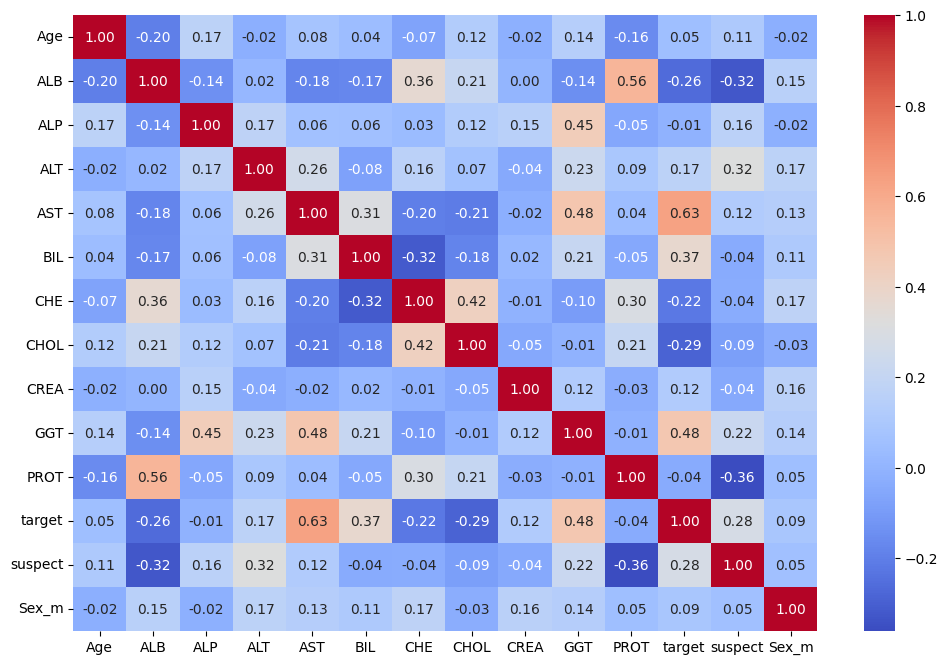

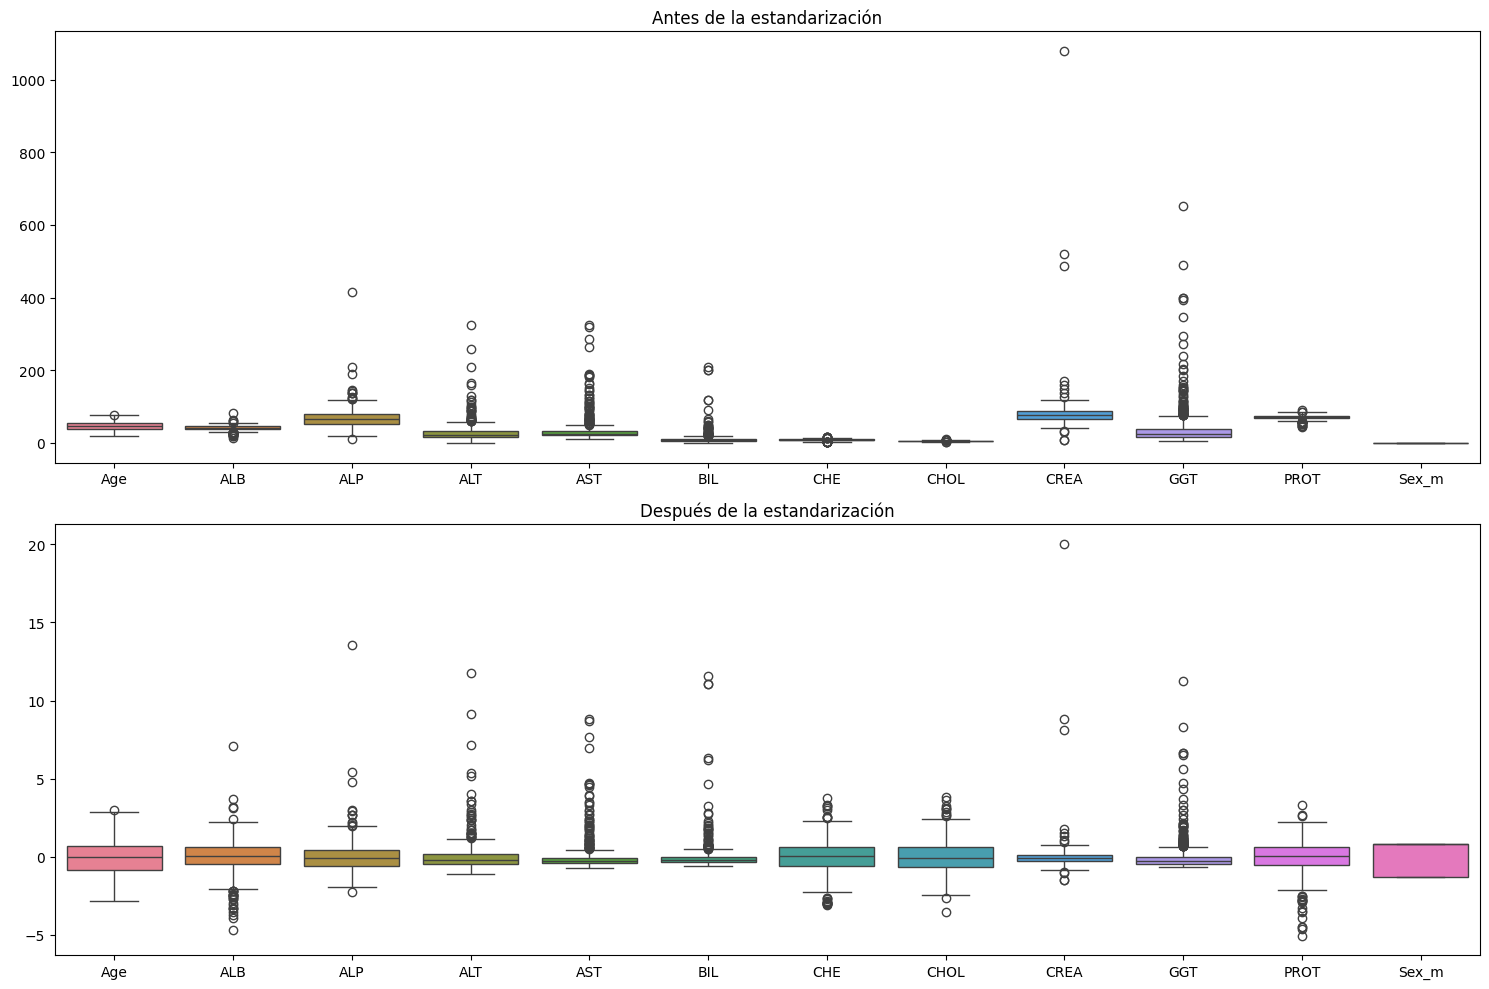

'La estandarización reduce el sesgo de la distribución.\nValores extremos o atípicos pueden tener una influencia menor después de la estandarización.\nAl tener todas las variables en la misma escala (media 0, desviación estándar 1), \nlas comparaciones entre diferentes variables se vuelven más significativas y los cambios en los percentiles se reflejan más claramente.'

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb

#FernandoSanchez Cargar los datos
data = pd.read_csv('hcvdat0.csv')

#FernandoSanchez Eliminar la columna 'Unnamed: 0'
data.drop(columns=['Unnamed: 0'], inplace=True)

#FernandoSanchez Revisar las primeras filas y las columnas
print(data.head())
print(data.columns)

#FernandoSanchez Codificar la variable objetivo 'Category'
data['target'] = np.where(data['Category'] == '0=Blood Donor', 0, 1)
data['suspect'] = np.where(data['Category'] == '0s=suspect Blood Donor', 1, 0)

#FernandoSanchez Eliminar la columna 'Category'
data.drop(columns=['Category'], inplace=True)

#FernandoSanchez Revisar las primeras filas para asegurarse de que la codificación es correcta
print(data.head())

#FernandoSanchez Revisar valores ausentes
missing_data = data.isnull().mean() * 100
print("Porcentaje de valores ausentes por columna:\n", missing_data)

#FernandoSanchez Manejo de valores ausentes
#FernandoSanchez Si el porcentaje de valores ausentes es menor a 1%, eliminar filas
data = data.dropna(thresh=int(len(data.columns) * 0.99))

#FernandoSanchez Reemplazar valores ausentes por el promedio según la clase para columnas con más del 1% de valores ausentes
for column in data.columns:
    if data[column].isnull().mean() > 0:
        data[column].fillna(data.groupby('target')[column].transform('mean'), inplace=True)

#FernandoSanchez Análisis descriptivo
desc_stats = data.describe()
print("Estadísticas descriptivas:\n", desc_stats)

#FernandoSanchez Visualización de distribuciones
data.hist(bins=20, figsize=(14, 10))
plt.show()

#FernandoSanchez Boxplots para revisar outliers
fig, axes = plt.subplots(len(data.columns)//3, 3, figsize=(15, 20))
for i, col in enumerate(data.columns):
    if col not in ['target', 'suspect']:
        sns.boxplot(y=data[col], ax=axes[i//3, i%3])
plt.tight_layout()
plt.show()

#FernandoSanchez Convertir la columna 'Sex' a variables dummy
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)

#FernandoSanchez Heatmap de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

"""Correlaciones Fuertes con target:
AST (0.628): Existe una correlación positiva fuerte entre AST (Aspartato aminotransferasa) y el target. 
Un aumento en AST está asociado con un aumento en la probabilidad de no ser un donante de sangre.
BIL (0.375): La bilirrubina también muestra una correlación positiva significativa con el target.
GGT (0.479): La Gamma-glutamil transferasa tiene una correlación positiva considerable con el target.
Correlaciones Fuertes con suspect:
ALT (0.315): La Alanina aminotransferasa tiene una correlación positiva significativa con ser un donante sospechoso.
ALP (0.163): La Fosfatasa alcalina muestra una correlación positiva menor con suspect.
Otras Correlaciones Notables:
ALB y PROT (0.558): Existe una fuerte correlación positiva entre la albúmina y las proteínas totales.
CHE y CHOL (0.424): La colinesterasa y el colesterol tienen una correlación positiva moderada.
Edad (Age): La edad promedio de los individuos es de aproximadamente 47.3 años, con una desviación estándar de 10 años. La edad mínima es 19 años y la máxima es 77 años.
Albúmina (ALB): La media es de 41.7 g/L con un rango de 14.9 a 82.2 g/L.
Fosfatasa alcalina (ALP): La media es de 68.3 U/L con una desviación estándar de 25.7 U/L. Los valores varían significativamente desde 11.3 hasta 416.6 U/L.
Bilirrubina (BIL): El promedio es de 11.0 µmol/L, pero con una alta variabilidad, indicando posibles valores atípicos o casos extremos.
Colesterol (CHOL): La media es de 5.4 mmol/L, con un rango de 1.43 a 9.67 mmol/L.
Gamma-glutamil transferasa (GGT): Alta variabilidad con una media de 39.0 U/L y un máximo de 650.9 U/L.
Proteínas totales (PROT): La media es de 72.0 g/L, dentro de un rango de 44.8 a 90.0 g/L.
Target: El 12.9% de los individuos no son donantes de sangre, mientras que solo el 1.1% son sospechosos."""

#FernandoSanchez Separar características y la variable objetivo
X = data.drop(columns=['target', 'suspect'])
y = data['target']

#FernandoSanchez Estandarizar las variables regresoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#FernandoSanchez Mostrar antes y después de la estandarización usando boxplots
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.boxplot(data=X, ax=axes[0])
axes[0].set_title('Antes de la estandarización')
sns.boxplot(data=pd.DataFrame(X_scaled, columns=X.columns), ax=axes[1])
axes[1].set_title('Después de la estandarización')
plt.tight_layout()
plt.show()

#FernandoSanchez Segmentar la muestra en 33% para test y el resto para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

"""La estandarización reduce el sesgo de la distribución.
Valores extremos o atípicos pueden tener una influencia menor después de la estandarización.
Al tener todas las variables en la misma escala (media 0, desviación estándar 1), 
las comparaciones entre diferentes variables se vuelven más significativas y los cambios en los percentiles se reflejan más claramente."""

2. Desarrolla un modelo regresión logística con validación cruzada usando 5-fold, con
regularización Elastic Net. Busca para los siguientes hiper parámetros:
● Cs: valores entre 0.01 y 5.0, con 200 valores lineales.
● l1_ratio: valores entre 0 y 1, con 200 valores lineales.
Muestra los valores óptimos encontrados, y las métricas precisión, recall, f1-score y
accuracy. Describe cuáles son las tres características con mayor incidencia en la
predicción de sujeto o muestra con sangre con posible enfermedad.

In [13]:
#FernandoSanchez Definir los rangos de hiperparámetros para la búsqueda
Cs = np.linspace(0.01, 5.0, 200)
l1_ratios = np.linspace(0, 1, 200)

#FernandoSanchez Inicializar el modelo de regresión logística con validación cruzada y regularización Elastic Net
model = LogisticRegressionCV(Cs=Cs, cv=5, penalty='elasticnet', solver='saga', l1_ratios=l1_ratios, n_jobs=-1, random_state=42)

#FernandoSanchez Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

#FernandoSanchez Obtener los valores óptimos encontrados
optimal_C = model.C_[0]
optimal_l1_ratio = model.l1_ratio_[0]

#FernandoSanchez Imprimir los valores óptimos encontrados
print("Valores óptimos encontrados:")
print(f"- Valor óptimo de C: {optimal_C}")
print(f"- Valor óptimo de l1_ratio: {optimal_l1_ratio}")

#FernandoSanchez Realizar predicciones en los datos de prueba
y_pred = model.predict(X_test)

#FernandoSanchez Imprimir las métricas de evaluación
print("Métricas de Evaluación:")
print(classification_report(y_test, y_pred))

#FernandoSanchez Características con mayor incidencia en la predicción de sujeto con posible enfermedad
coefficients = model.coef_[0]
feature_importance = {feature: coef for feature, coef in zip(X.columns, coefficients)}
top_features = sorted(feature_importance, key=feature_importance.get, reverse=True)[:3]

print("\nLas tres características con mayor incidencia en la predicción de sujeto o muestra con posible enfermedad son:")
for feature in top_features:
    print(f"- {feature}: {feature_importance[feature]}")

"""Los valores óptimos encontrados son C=2.141407035175879 y l1_ratio=0.0. 
Además, las métricas de evaluación muestran un alto rendimiento del modelo, con una precisión y recall promedio del 93% y 78% respectivamente.

Las tres características con mayor incidencia en la predicción de sujetos o muestras con posible enfermedad son GGT, AST y BIL, con coeficientes de 1.624, 1.374 y 0.924 
respectivamente."""

Valores óptimos encontrados:
- Valor óptimo de C: 2.141407035175879
- Valor óptimo de l1_ratio: 0.0
Métricas de Evaluación:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       172
           1       0.94      0.57      0.71        30

    accuracy                           0.93       202
   macro avg       0.94      0.78      0.83       202
weighted avg       0.93      0.93      0.92       202


Las tres características con mayor incidencia en la predicción de sujeto o muestra con posible enfermedad son:
- GGT: 1.6242332310906527
- AST: 1.374280854018327
- BIL: 0.9242991755200525


3. Implementa un modelo Extreme Gradient Boosting con búsqueda de hiper
parámetros de grilla, con regularización para la combinación L1 y L2. Considera para
esto:
a. reg_lambda: valores entre 0.0 y 2.0, con 10 valores lineales.
b. reg_alpha: valores entre 0 y 1, con 10 valores lineales.
c. learning_rate: valores entre 0.1 a 10, con 20 valores lineales.


In [15]:
#FernandoSanchez Definir los parámetros a buscar en la grilla
param_grid = {
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0.0, 2.0, 10),
    'learning_rate': np.linspace(0.1, 10, 20)
}

#FernandoSanchez Inicializar el clasificador XGBoost
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

#FernandoSanchez Configurar la búsqueda de grilla con validación cruzada
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy')

#FernandoSanchez Entrenar el modelo con la búsqueda de grilla
grid_search.fit(X_train, y_train)

#FernandoSanchez Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

#FernandoSanchez Obtener las predicciones del mejor modelo
y_pred_xgb = grid_search.predict(X_test)

#FernandoSanchez Evaluar el modelo
print("\nMétricas de Evaluación del Modelo XGBoost:")
print(classification_report(y_test, y_pred_xgb))

#FernandoSanchez Nivel de importancia de los atributos
importance = grid_search.best_estimator_.feature_importances_
print("\nNivel de importancia de los atributos:")
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))

"""El modelo muestra un alto desempeño en la clasificación de ambas clases, con una precisión, recall y f1-score superiores al 0.9 para la clase 0 (sin enfermedad) 
y valores cercanos al 0.9 para la clase 1 (con enfermedad). 
Además, la importancia de los atributos indica que las características más influyentes en la predicción son la feature 4 (GGT) seguida por la feature 3 (ALT)."""

Mejores parámetros encontrados:
{'learning_rate': 1.6631578947368424, 'reg_alpha': 0.3333333333333333, 'reg_lambda': 1.3333333333333333}

Métricas de Evaluación del Modelo XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       172
           1       0.93      0.83      0.88        30

    accuracy                           0.97       202
   macro avg       0.95      0.91      0.93       202
weighted avg       0.96      0.97      0.96       202


Nivel de importancia de los atributos:
Feature: 0, Score: 0.00022
Feature: 1, Score: 0.00323
Feature: 2, Score: 0.01441
Feature: 3, Score: 0.09908
Feature: 4, Score: 0.72477
Feature: 5, Score: 0.00840
Feature: 6, Score: 0.01049
Feature: 7, Score: 0.02255
Feature: 8, Score: 0.00230
Feature: 9, Score: 0.08584
Feature: 10, Score: 0.02723
Feature: 11, Score: 0.00148


4. Muestra el nivel de importancia de los atributos, los valores óptimos de los hiper
parámetros y las métricas precisión, recall, f1-score y accuracy. Compara los
resultados de este modelo con el de regresión logística.

In [16]:
"""Comparando ambos modelos, observamos que el modelo de XGBoost presenta un rendimiento superior en general. 
La precisión, recall y f1-score para ambas clases son más altos en el modelo de XGBoost en comparación con la regresión logística. 
Esto sugiere que el modelo de XGBoost es más efectivo para clasificar correctamente las muestras, especialmente para la clase minoritaria (con enfermedad),
 donde la regresión logística tenía un recall bajo. 
Además, la precisión global y el accuracy son más altos para el modelo de XGBoost, lo que indica una mejor capacidad de generalización."""

'Comparando ambos modelos, observamos que el modelo de XGBoost presenta un rendimiento superior en general. \nLa precisión, recall y f1-score para ambas clases son más altos en el modelo de XGBoost en comparación con la regresión logística. \nEsto sugiere que el modelo de XGBoost es más efectivo para clasificar correctamente las muestras, especialmente para la clase minoritaria (con enfermedad),\n donde la regresión logística tenía un recall bajo. \nAdemás, la precisión global y el accuracy son más altos para el modelo de XGBoost, lo que indica una mejor capacidad de generalización.'